In [4]:
import os
root_dir='/kaggle/input/celeba-dataset'
os.path.join(root_dir, 'list_attr_celeba.csv')
os.path.join(root_dir, 'img_align_celeba','img_align_celeba', '1')


'/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/1'

In [5]:
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd


class CelebAGenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        attr_path = os.path.join(root_dir, 'list_attr_celeba.csv')
        if not os.path.exists(attr_path):
            raise FileNotFoundError(f"Attribute file not found at {attr_path}")

        self.attr_df = pd.read_csv(attr_path)
        self.attr_df.columns = self.attr_df.columns.str.strip()

        self.attr_df = self.attr_df[['image_id', 'Male']]

        # Convert labels: 1 = male, -1 = female
        self.attr_df['Male'] = (self.attr_df['Male'] == 1).astype(int)

        img_dir = os.path.join(root_dir, 'img_align_celeba','img_align_celeba')
        existing_files = set(os.listdir(img_dir))
        self.attr_df = self.attr_df[self.attr_df['image_id'].isin(existing_files)]

        self.records = list(zip(self.attr_df['image_id'], self.attr_df['Male']))


    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        fname, label = self.records[idx]
        img_path = os.path.join(self.root_dir, 'img_align_celeba','img_align_celeba', fname)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
dataset = CelebAGenderDataset(root_dir=root_dir).records
dataset[0]
# print(dataset)

('000001.jpg', 0)

torch.Size([32, 3, 224, 224]) torch.Size([32])


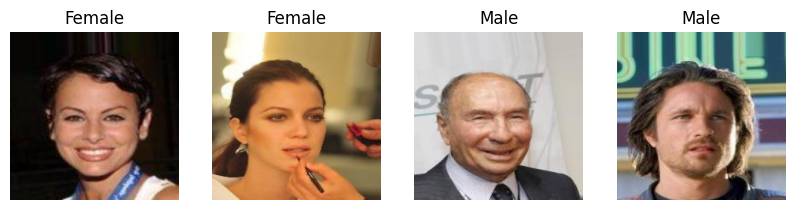

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = CelebAGenderDataset(root_dir=root_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(loader))
print(images.shape, labels.shape)

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
for i in range(4):
    img = images[i]
    img = img.permute(1, 2, 0)   # CHW → HWC
    axes[i].imshow(img)
    axes[i].set_title("Male" if labels[i] == 1 else "Female")
    axes[i].axis("off")
plt.show()

In [7]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 1. read files
attr_path = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
img_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"  
df = pd.read_csv(attr_path)

# 2.maping the gender with 0,1 
df['gender'] = df['Male'].apply(lambda x: "male" if x == 1 else "female")

# 3. balancing
male_df = df[df['gender'] == "male"]
female_df = df[df['gender'] == "female"]

min_count = min(len(male_df), len(female_df))

balanced_df = pd.concat([
    male_df.sample(min_count, random_state=42),
    female_df.sample(min_count, random_state=42)
]).reset_index(drop=True)

print("Balanced dataset size:", balanced_df['gender'].value_counts())

class CelebAGenderDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"female": 0, "male": 1}  # 0=female, 1=male

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'])
        img = Image.open(img_path).convert("RGB")
        label = self.label_map[row['gender']]

        if self.transform:
            img = self.transform(img)

        return img, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 6. Dataset + DataLoader
dataset = CelebAGenderDataset(balanced_df, img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# batching
images, labels = next(iter(dataloader))
print("Batch images shape:", images.shape)
print("Batch labels shape:", labels.shape)


Balanced dataset size: gender
male      84434
female    84434
Name: count, dtype: int64
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GenderCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(GenderCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # GAP
        x = self.gap(x)   # [batch, 128, 1, 1]
        x = x.view(x.size(0), -1)  # [batch, 128]

        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [ ]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GenderCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop (simple)
for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(dataloader):.4f}, "
          f"Accuracy: {100*correct/total:.2f}%")


In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

# =========================================================
# 1) Load Attributes CSV (list_attr_celeba.csv)
# =========================================================
attr_path = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
img_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba" 

df = pd.read_csv(attr_path)
df = df.reset_index().rename(columns={"index":"image_id"})

# 'Male' column: -1 = female, 1 = male
df['gender'] = df['Male'].apply(lambda x: 1 if x == 1 else 0)

# Balance dataset: equal males/females
min_count = min(df[df['gender']==0].shape[0], df[df['gender']==1].shape[0])
balanced_df = pd.concat([
    df[df['gender']==0].sample(min_count, random_state=42),
    df[df['gender']==1].sample(min_count, random_state=42)
]).reset_index(drop=True)

# =========================================================
# 2) Train/Valid Split
# =========================================================
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['gender'], random_state=42)

# =========================================================
# 3) Custom Dataset
# =========================================================
class CelebaDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # الـصور في CelebA اسمها أرقام متسلسلة 000001.jpg, 000002.jpg ...
        img_name = f"{str(row.name+1).zfill(6)}.jpg"
        img_path = os.path.join(self.img_dir, img_name)
        
        image = Image.open(img_path).convert("RGB")
        label = row['gender']
        
        if self.transform:
            image = self.transform(image)
        return image, label


# =========================================================
# 4) Transforms (resize smaller for speed)
# =========================================================
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_dataset = CelebaDataset(train_df, img_dir, transform=train_transform)
val_dataset   = CelebaDataset(val_df, img_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# =========================================================
# 5) Model: Pretrained ResNet18
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: male/female
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# =========================================================
# 6) Training Loop with AMP + Early Stopping
# =========================================================
scaler = torch.cuda.amp.GradScaler()
best_val_acc = 0
patience, patience_counter = 3, 0

for epoch in range(10):  # max 10 epochs
    # ---- Training ----
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f}")
    
    # ---- Validation ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    val_acc = correct / total
    print(f"Validation Acc: {val_acc:.4f}")
    
    # # ---- Early Stopping ----
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     torch.save(model.state_dict(), "best_model.pth")
    #     patience_counter = 0
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered!")
    #         break
torch.save(model.state_dict(), "best_model.pth")
print("Best Validation Accuracy:", best_val_acc)


/tmp/ipykernel_36/371881021.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_36/371881021.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 0.7049 | Train Acc: 0.4996
Validation Acc: 0.4996
Epoch 2 | Train Loss: 0.6951 | Train Acc: 0.5047
Validation Acc: 0.5000
Epoch 3 | Train Loss: 0.6947 | Train Acc: 0.5061
Validation Acc: 0.4999
Epoch 4 | Train Loss: 0.6939 | Train Acc: 0.5081
Validation Acc: 0.5012
Epoch 5 | Train Loss: 0.6930 | Train Acc: 0.5171
Validation Acc: 0.4998
Epoch 6 | Train Loss: 0.6898 | Train Acc: 0.5345
Validation Acc: 0.5029
Epoch 7 | Train Loss: 0.6809 | Train Acc: 0.5610
Validation Acc: 0.5014
Epoch 8 | Train Loss: 0.6598 | Train Acc: 0.6023
Validation Acc: 0.5008
Epoch 9 | Train Loss: 0.6222 | Train Acc: 0.6497
Validation Acc: 0.4968
Epoch 10 | Train Loss: 0.5658 | Train Acc: 0.7032
Validation Acc: 0.4985
Best Validation Accuracy: 0


In [9]:
!nvidia-smi

Wed Sep 24 06:54:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             33W /  250W |    1037MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
# ===============================
# CelebA Gender (Binary) — Fast, Stable, Real-time Ready
# ===============================
import os
import math
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split

# -------------------------------
# 0) Reproducibility + Device
# -------------------------------
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True  # faster on image tasks
seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fp16_ok = torch.cuda.is_available()

# -------------------------------
# 1) Paths & DataFrame
# -------------------------------
attr_path = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
img_dir   = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

df = pd.read_csv(attr_path)

# Expectation:
# - df contains either a column with filenames (e.g., "image_id" = "000001.jpg")
#   OR a numeric id we can turn into "000001.jpg"
# If your column name differs, set it here:
FILENAME_COL = "image_id" if "image_id" in df.columns else None
if FILENAME_COL is None:
    # fallback: build from index if no filename column exists (rare)
    df = df.reset_index().rename(columns={"index": "image_id"})
    FILENAME_COL = "image_id"

# Gender mapping: CelebA 'Male' column is -1 (female) / 1 (male); convert to 0/1
if "Male" in df.columns:
    df["gender"] = df["Male"].apply(lambda x: 1 if x == 1 else 0)
else:
    raise ValueError("CSV must contain 'Male' column from CelebA attributes.")

# Balance dataset
min_count = min((df["gender"] == 0).sum(), (df["gender"] == 1).sum())
balanced_df = pd.concat([
    df[df["gender"] == 0].sample(min_count, random_state=42),
    df[df["gender"] == 1].sample(min_count, random_state=42),
], ignore_index=True)

# -------------------------------
# 2) Split
# -------------------------------
train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df["gender"],
    random_state=42
)

# -------------------------------
# 3) Dataset
# -------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class CelebaDataset(Dataset):
    def __init__(self, dataframe, img_dir, filename_col, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.filename_col = filename_col
        self.transform = transform

    def _resolve_filename(self, row):
        val = row[self.filename_col]
        # Supports either "000123.jpg" or numeric index/id
        if isinstance(val, str) and val.lower().endswith(".jpg"):
            return val
        try:
            num = int(val)
            return f"{num:06d}.jpg"
        except Exception:
            # if the DataFrame index maps to celebA order (rarely needed)
            idx_based = f"{(row.name + 1):06d}.jpg"
            return idx_based

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = self._resolve_filename(row)
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        label = int(row["gender"])

        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CelebaDataset(train_df, img_dir, FILENAME_COL, train_transform)
val_dataset   = CelebaDataset(val_df,   img_dir, FILENAME_COL, val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=True
)

# -------------------------------
# 4) Model: MobileNetV3-Small (fast)
# -------------------------------
model = models.mobilenet_v3_small(weights="IMAGENET1K_V1")
in_feats = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_feats, 2)
model = model.to(device)

# Bandwidth/layout wins
model = model.to(memory_format=torch.channels_last)

# Loss with light label smoothing to reduce overfit variance
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# AdamW + cosine schedule — good defaults
def make_optimizer(params, lr=1e-3, wd=1e-4):
    return optim.AdamW(params, lr=lr, weight_decay=wd)

# Warmup + cosine
def make_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# -------------------------------
# 5) Training helpers
# -------------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=fp16_ok):
            outputs = model(images)
        pred = outputs.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return correct / max(1, total)

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=fp16_ok):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pred = outputs.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / max(1, total)
    avg_loss = running_loss / max(1, len(loader))
    return avg_loss, train_acc

# -------------------------------
# 6) Training: linear probe → full finetune
# -------------------------------
epochs_probe = 2
epochs_full  = 10
max_epochs   = epochs_probe + epochs_full

# Freeze backbone for a short linear probe (stabilizes head)
for name, p in model.named_parameters():
    if not name.startswith("classifier"):  # freeze everything except classifier
        p.requires_grad = False

optimizer = make_optimizer(model.classifier.parameters(), lr=3e-4, wd=1e-4)
total_steps = max_epochs * len(train_loader)
scheduler = make_scheduler(optimizer, warmup_steps=max(10, len(train_loader)//2), total_steps=total_steps)
scaler = torch.cuda.amp.GradScaler(enabled=fp16_ok)

best_val = 0.0
patience, bad_epochs = 3, 0

global_step = 0
for epoch in range(1, max_epochs + 1):
    # Unfreeze after probe
    if epoch == (epochs_probe + 1):
        for p in model.parameters(): p.requires_grad = True
        optimizer = make_optimizer(model.parameters(), lr=1e-3, wd=1e-4)  # higher LR to start, cosine will anneal
        scheduler = make_scheduler(optimizer, warmup_steps=max(50, len(train_loader)), total_steps=total_steps)

    loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    scheduler.step()
    global_step += len(train_loader)

    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch:02d}/{max_epochs} | loss {loss:.4f} | train_acc {train_acc:.4f} | val_acc {val_acc:.4f}")

    # Early stopping on val acc
    if val_acc > best_val:
        best_val = val_acc
        bad_epochs = 0
        torch.save(model.state_dict(), "best_mobilenetv3_small_gender.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping: no improvement.")
            break

print(f"Best Validation Accuracy: {best_val:.4f}")

# -------------------------------
# 7) Inference helper (real-time frame → label)
# -------------------------------
infer_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

@torch.no_grad()
def predict_tensor(model, img_tensor):  # img_tensor: 1x3xHxW, preprocessed
    model.eval()
    img_tensor = img_tensor.to(device).to(memory_format=torch.channels_last)
    with torch.cuda.amp.autocast(enabled=fp16_ok):
        logits = model(img_tensor)
    prob = logits.softmax(dim=1)
    cls = prob.argmax(1).item()
    conf = prob.max(1).values.item()
    return cls, conf

def predict_pil(model, pil_image):
    t = infer_transform(pil_image).unsqueeze(0)
    return predict_tensor(model, t)


# -------------------------------
# 8) (Optional) Export to ONNX for deployment
# -------------------------------
def export_onnx(model, path="mobilenetv3_gender.onnx"):
    model.eval()
    dummy = torch.randn(1, 3, 224, 224, device=device).to(memory_format=torch.channels_last)
    torch.onnx.export(
        model, dummy, path,
        input_names=["images"], output_names=["logits"],
        opset_version=12, do_constant_folding=True, dynamic_axes={"images": {0: "batch"}, "logits": {0: "batch"}}
    )
    print(f"Exported ONNX to {path}")

# export_onnx(model)  # uncomment when you want the ONNX artifact


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 106MB/s]
/tmp/ipykernel_36/2794188307.py:223: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=fp16_ok)
/tmp/ipykernel_36/2794188307.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=fp16_ok):
/tmp/ipykernel_36/2794188307.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=fp16_ok):


Epoch 01/12 | loss 0.6969 | train_acc 0.5304 | val_acc 0.5387
Epoch 02/12 | loss 0.6581 | train_acc 0.6132 | val_acc 0.7048
Epoch 03/12 | loss 0.6235 | train_acc 0.6863 | val_acc 0.7050
Epoch 04/12 | loss 0.5317 | train_acc 0.7961 | val_acc 0.8515
Epoch 05/12 | loss 0.3757 | train_acc 0.8782 | val_acc 0.8985
Epoch 06/12 | loss 0.2889 | train_acc 0.9151 | val_acc 0.9236
Epoch 07/12 | loss 0.2511 | train_acc 0.9351 | val_acc 0.9389
Epoch 08/12 | loss 0.2292 | train_acc 0.9468 | val_acc 0.9508
Epoch 09/12 | loss 0.2135 | train_acc 0.9543 | val_acc 0.9569
Epoch 10/12 | loss 0.2025 | train_acc 0.9597 | val_acc 0.9629
Epoch 11/12 | loss 0.1941 | train_acc 0.9640 | val_acc 0.9672
Epoch 12/12 | loss 0.1864 | train_acc 0.9676 | val_acc 0.9692
Best Validation Accuracy: 0.9692


In [11]:
export_onnx(model)  # uncomment when you want the ONNX artifact


Exported ONNX to mobilenetv3_gender.onnx


In [15]:
# Example usage after training:
from PIL import Image
pil = Image.open("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg").convert("RGB")
label, conf = predict_pil(model, pil)
print(label, conf)

0 0.955078125


/tmp/ipykernel_36/2794188307.py:270: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=fp16_ok):
